In [43]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import imodelsx.llm
from transformers import AutoModel, AutoTokenizer, pipeline
from tqdm import tqdm
from os.path import join
import config
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import analyze_helper
fit_encoding = __import__('01_fit_encoding')


results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_apr7'
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 147/147 [00:20<00:00,  7.19it/s]

experiment varied these params: ['feature_space', 'distill_model_path', 'feature_selection_alpha_index', 'qa_embedding_model', 'qa_questions_version', 'pc_components', 'ndelays', 'seed']


# Check results

In [48]:
d = r
d = d[d.feature_selection_alpha_index >= 0]
d = d[d.distill_model_path == 'None']
cols_varied = [c for c in cols_varied if not c in [
    'distill_model_path']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets + ['weight_enet_mask_num_nonzero']].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by='corrs_tune_pc_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)
d = d.reset_index()

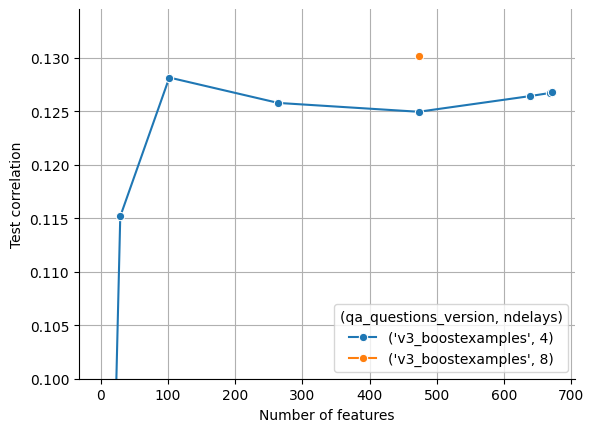

In [50]:
d['(qa_questions_version, ndelays)'] = list(
    zip(d.qa_questions_version, d.ndelays))

sns.lineplot(data=d, x='weight_enet_mask_num_nonzero',
             y='corrs_test_mean', hue='(qa_questions_version, ndelays)', marker='o')
plt.xlabel('Number of features')
plt.ylabel('Test correlation')

# set ylim bottom to 0.1
plt.ylim(bottom=0.1)
plt.grid()
plt.show()

# Check sparsity levels

In [ ]:
sparse_feats_dir = join(config.repo_dir, 'sparse_feats')

In [ ]:
!ls {sparse_feats_dir}

In [ ]:
alphas_enet, coefs_enet = joblib.load(
    join(sparse_feats_dir, 'v3_boostexamples_(0, -3, 15).joblib'))

In [ ]:
for i in range(len(alphas_enet)):
    coef_enet = coefs_enet[:, :, i]
    coef_nonzero = np.any(np.abs(coef_enet) > 0, axis=0)
    print(f'{i=} alpha={alphas_enet[i]:.2e}, n_nonzero={coef_nonzero.sum()}')

### Top questions